# df

In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = 'Module_6_Lecture_1_CoNLL2003/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

In [4]:
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

In [5]:
train_sents[:3]

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

In [6]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [7]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}

In [8]:
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

In [9]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]
    
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2

word2id = {}

for idx, word in enumerate(word_dict.keys()):
    word2id[word] = idx

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])

    return idxs

In [32]:
to_check = 102

prepared_data = prepare_sequence(train_df['text'][to_check], word2id)
label = train_df['label'][to_check]
raw_data = train_df['text'][to_check]
too_raw_data = train_sents[to_check]

print(f'Prepared data: {prepared_data}')
print(f'Label: {label}')
print(f'Raw data: {raw_data}')
print(f'Too raw data: {too_raw_data}')

Prepared data: [613, 16, 43, 664, 605, 73, 665, 67, 666, 630, 67, 377, 18, 53, 667, 3, 620, 80, 637, 3, 668, 632, 669, 670, 7]
Label: [5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Raw data: ['Israel', 'on', 'Wednesday', 'sent', 'Syria', 'a', 'message', ',', 'via', 'Washington', ',', 'saying', 'it', 'was', 'committed', 'to', 'peace', 'and', 'wanted', 'to', 'open', 'negotiations', 'without', 'preconditions', '.']
Too raw data: [('Israel', 'B-LOC'), ('on', 'O'), ('Wednesday', 'O'), ('sent', 'O'), ('Syria', 'B-LOC'), ('a', 'O'), ('message', 'O'), (',', 'O'), ('via', 'O'), ('Washington', 'B-LOC'), (',', 'O'), ('saying', 'O'), ('it', 'O'), ('was', 'O'), ('committed', 'O'), ('to', 'O'), ('peace', 'O'), ('and', 'O'), ('wanted', 'O'), ('to', 'O'), ('open', 'O'), ('negotiations', 'O'), ('without', 'O'), ('preconditions', 'O'), ('.', 'O')]


In [11]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output
    
collate_fn = Collate(True)  

In [12]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)#, freeze=True)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        
        lstm_output, _ = self.lstm(embeddings) 

        logits = self.fc(lstm_output)
        return logits

In [13]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    # for epoch in range(max_epochs):
    for epoch in tqdm(range(max_epochs), desc="Epochs"):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        # for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):
        for batch in train_loader:
            
            cur_batch_size, text_length = batch['input_ids'].shape
            
            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)
            
        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)
        
        total_loss = 0
        predictions, correct = [], []
        
        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape
                
                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)
                
                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")
            
        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)
        
        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

In [14]:
def test(model, test_iter, batch_size, labels, target_names): 
    total_loss = 0
    predictions, correct = [], []
    
    model.eval()
    with torch.no_grad():    
    
        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())



            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [15]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)

In [16]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

In [17]:
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

In [18]:
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES) 
tagger

BiLSTMTagger(
  (embeddings): Embedding(11986, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [19]:
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Total training loss: 337.196904823184
Training Macro F1: 0.035226510071663095
Total validation loss: 52.1132005751133
Validation Macro F1: 0.18429102239874962
Saving model.
Total training loss: 159.1492236237973
Training Macro F1: 0.35249762541557017
Total validation loss: 30.063167622312903
Validation Macro F1: 0.40968588031067005
Saving model.
Total training loss: 89.93668925110251
Training Macro F1: 0.5886224096023904
Total validation loss: 22.996962933801115
Validation Macro F1: 0.6234341999549682
Saving model.
Total training loss: 54.58377280132845
Training Macro F1: 0.7163602217842109
Total validation loss: 19.176737124100327
Validation Macro F1: 0.6756289233524693
Saving model.
Total training loss: 35.01707430323586
Training Macro F1: 0.7824910679879308
Total validation loss: 16.79302114818711
Validation Macro F1: 0.7107519525607453
Saving model.
Total training loss: 22.966040141764097
Training Macro F1: 0.8215979854946225
Total validation loss: 17.002956366108265
Validation Mac

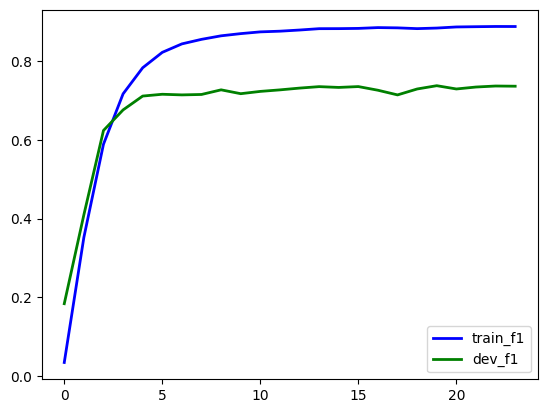

In [20]:
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f1': train_f, 
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()

In [23]:
# tagger = torch.load(OUTPUT_PATH)

In [22]:
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

       B-PER       0.86      0.68      0.76      1617
       I-PER       0.90      0.74      0.81      1156
       B-ORG       0.80      0.64      0.71      1661
       I-ORG       0.84      0.69      0.76       835
       B-LOC       0.91      0.76      0.82      1668
       I-LOC       0.85      0.63      0.72       257
      B-MISC       0.79      0.67      0.72       702
      I-MISC       0.74      0.61      0.67       216

   micro avg       0.85      0.69      0.76      8112
   macro avg       0.84      0.68      0.75      8112
weighted avg       0.85      0.69      0.76      8112

